In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

## Table of Contents

- [1. The original code](#1.-The-original-code)
- [2. Making our code executable at the command-line](#2.-Making-our-code-executable-at-the-command-line)
- [3. Adding command-line arguments](#3.-Adding-command-line-arguments)
- [4. Separating implementation from user interface](#4.-Separating-implementation-from-user-interface)
- [5. Separating library files from program files](#5.-Separating-library-files-from-program-files)
- [6. Making a Python package](#6.-Making-a-Python-package)
- [7. Packaging and installation](#7.-Packaging-and-installation)
- [Bonus enhancements](#Bonus-enhancements)

## 1. The original code

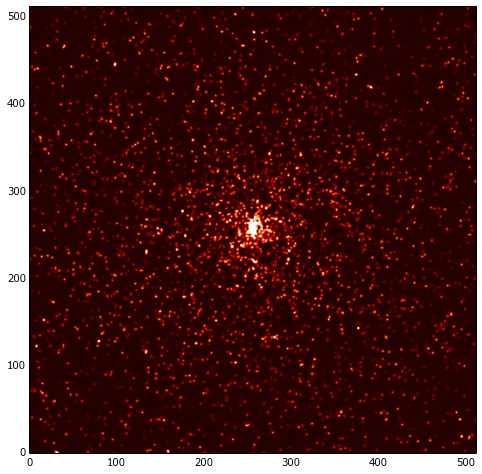

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter

# Create empty image
nx, ny = 512, 512
image = np.zeros((ny, nx))

# Set number of stars
n_stars = 10000

# Generate random positions
r = np.random.random(n_stars) * nx
theta = np.random.uniform(0., 2. * np.pi, n_stars)

# Generate random fluxes
fluxes = np.random.random(n_stars) ** 2

# Compute position
x = nx / 2 + r * np.cos(theta)
y = ny / 2 + r * np.sin(theta)

# Add stars to image
# ==> First for loop and if statement <==
for idx in range(n_stars):
    if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
        image[y[idx], x[idx]] += fluxes[idx]

# Convolve with a gaussian
image = gaussian_filter(image, sigma=1)

# Add noise
image += np.random.normal(1., 0.001, image.shape)

# Write to a PNG
plt.figure(figsize=(8, 8))
# Nice vmin and vmax were pre-computed using a percentile function, excluded
# for simplicity of the example
plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
plt.savefig('cluster.png')

[^Back to top](#Table-of-Contents)

## 2. Making our code executable at the command-line

First thing's first, make this into an executable script by adding a "shebang" line, like

    #!/usr/bin/env python
    
This indicates to your shell to run the remainder of this file through Python with a copy of your current shell environment.  We also use IPython's `%%file` magic to write this out as a file on disk:

In [3]:
%%file simcluster.py
#!/usr/bin/env python
import sys
print(sys.executable)
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter

# Create empty image
nx, ny = 512, 512
image = np.zeros((ny, nx))

# Set number of stars
n_stars = 10000

# Generate random positions
r = np.random.random(n_stars) * nx
theta = np.random.uniform(0., 2. * np.pi, n_stars)

# Generate random fluxes
fluxes = np.random.random(n_stars) ** 2

# Compute position
x = nx / 2 + r * np.cos(theta)
y = ny / 2 + r * np.sin(theta)

# Add stars to image
# ==> First for loop and if statement <==
for idx in range(n_stars):
    if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
        image[y[idx], x[idx]] += fluxes[idx]

# Convolve with a gaussian
image = gaussian_filter(image, sigma=1)

# Add noise
image += np.random.normal(1., 0.001, image.shape)

plt.figure(figsize=(10, 10))
# Nice vmin and vmax were pre-computed using a percentile function, excluded
# for simplicity of the example
plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
plt.savefig('cluster.png')

Writing simcluster.py


We also want to set the "executable" bit on our file's permissions, which tells the shell that this is an executable file (i.e. if we enter the file's name at a command prompt it will try to run it as a program):

In [4]:
! chmod +x simcluster.py

`chmod` is the shell program for setting file permissions (it can also be used to set read/write permissions).  The `+x` option means to set the file `simcluster` as "executable" for all users (likewise `-x` removes the executable flag).

Unless you are running IPython from a Bash shell implementation for Windows (such as Git Bash) this will not work on Windows, where there is not normally a sense of "executable" files other than .exe files.

Now we can run our program at the command prompt (unless we're on Windows, in which case this will launch whatever program has been registered to open .py files, which may not be Python!--in other words Windows has no conception of a shebang):

In [5]:
! ./simcluster.py

/usr/bin/python


We include the `./` because without it the shell does not know where to look for the program named "simcluster".  If a program name is entered at the shell without an explicit path (like we do when we run `ls`, `chmod`, etc.) the shell searches all the entries on our `$PATH` environment variable for a program by that name.  We can check the `$PATH` using the shell like:

In [6]:
! echo $PATH

/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games


Or we can read and set environment variables directly in Python using the `os` module:

In [7]:
import os
print(os.environ['PATH'])

/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games


[^Back to top](#Table-of-Contents)

## 3. Adding command-line arguments

Getting back to our script, the next thing to do to make this script into a reusable program that others can use too, would be to note that we actually have several parameters for which specified some values that worked for us at the time, but that others (where "others" includes ourselves, in the future) may wish to adjust.

Perhaps most notably the file name that we wrote to (maybe "clobber.fits" doesn't do it for everyone).  Other parameters we might want to make adjustable would be the number of stars, and the dimensions (in pixels, for now) of the image.  Those are the only parameters we'll focus on for now--can you think of others?

It isn't very nice to have to modify our code every time we want to tweak some parameters.  Nevermind that we might not even remember what parameters we used to generate a particular image (did this have 10000 stars? or 12000?  I don't remember since I changed it since I last generated that image...).  Of course since we're writing to FITS files there are things we might do, like include keywords in the header specifying the parameters of the image).  But for ease of use we would like our script to accept command-line argument to set the number of stars, etc.  Then the command we used to generate that file would be in our shell history.  It also means that when we share are script with someone else we just have to tell them how to run it--not how to go in and edit the code.

How do Python scripts accept command-line arguments?

I've you've ever written a program in C you've probably written a main function like:

    int main(int argc, char** argv) { ... }
    
When you run your program, the program name itself along with any command-line arguments that followed the program name are passed in via an array of strings in `argv` (where `argc` tells us the number of arguments that were passed in).

In Python the equivalent is just a variable that lives in the `sys` module called `sys.argv`.  It gives us a `list` of all the command-line arguments.  To see this, let's just print `sys.argv` at the top of our script:

In [8]:
%%file simcluster.py
#!/usr/bin/env python
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter

# Let's take a look at the command-line arguments:
import sys
print(sys.argv)

# Create empty image
nx, ny = 512, 512
image = np.zeros((ny, nx))

# Set number of stars
n_stars = 10000

# Generate random positions
r = np.random.random(n_stars) * nx
theta = np.random.uniform(0., 2. * np.pi, n_stars)

# Generate random fluxes
fluxes = np.random.random(n_stars) ** 2

# Compute position
x = nx / 2 + r * np.cos(theta)
y = ny / 2 + r * np.sin(theta)

# Add stars to image
# ==> First for loop and if statement <==
for idx in range(n_stars):
    if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
        image[y[idx], x[idx]] += fluxes[idx]

# Convolve with a gaussian
image = gaussian_filter(image, sigma=1)

# Add noise
image += np.random.normal(1., 0.001, image.shape)

# Write to a PNG
plt.figure(figsize=(10, 10))
# Nice vmin and vmax were pre-computed using a percentile function, excluded
# for simplicity of the example
plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
plt.savefig('cluster.png')

Overwriting simcluster.py


In [9]:
! ./simcluster.py --stars=10000 -x 512 -y 512 cluster.png

['./simcluster.py', '--stars=10000', '-x', '512', '-y', '512', 'cluster.png']


What we would like to do is parse these command-line options so that we use the value of the `--stars` option to set our `n_stars` variable, and we also note that we accept `-x` and `-y` options that we want to take as our x and y dimensions.  We also need to handle the filename.

And remember when we said we'll want to explain to our colleagues how to use our program?  Well, if we provide them with a `--help` option, maybe we won't have to do even that, if it's a simple enough program.

Just to throw a wrench into things we also want to support `-s` as a shortcut for `--stars` and `-h` as a shortcut for `--help`.

We could spend a while writing all the code to handle these command-line arguments (rather than getting on with our science).  But fortunately, except in extreme cases, we don't have to do that.  This is already a solved problem, and there are *libraries* that will make it easy to add standard argument handling to our script.

Python comes out of the box with *three* such libraries:

 * [`getopt`](https://docs.python.org/2/library/getopt.html)
 * [`optparse`](https://docs.python.org/2/library/optparse.html)
 * [`argparse`](https://docs.python.org/2/library/argparse.html)
 
Why three?  Is this just to confuse you?  No!  It's because Python is a living language, and the standard library continues to evolve.  `getopt` is an interface to a C library of the same name, and is fairly basic.  `optparse` is a higher-level library that `getopt` that has been in Python for a long time, but was beginning to show its age.  `argparse` already existed as a third-party library, and (most) people liked it so much more than the old `optparse` that it was added as a replacement for `optparse` (`optparse` is kept around though so that old programs don't just break!)

We will take a brief look at `argparse`.  Here's one way we might go about adding argument parsing to our program with `argparse`:

In [10]:
%%file simcluster.py
#!/usr/bin/env python

import argparse  # We added a new import statement for argarse
import sys       # Also import sys for sys.argv

import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter

# Create an ArgumentParser--a special object that keeps track of all the
# arguments we want our script to be able to handle, and then implements parsing
# them from sys.argv
parser = argparse.ArgumentParser(description="Generates simulated images of clusters")

# Add an optional argument for # of stars (default=10000)
parser.add_argument('-s', '--stars', type=int, default=10000,
                    help='the number of stars to generate')

# Add the x and y arguments
parser.add_argument('-x', type=int, default=512,
                    help='the x dimension (in pixels) of the image')
parser.add_argument('-y', type=int, default=512,
                    help='the y dimension (in pixels) of the image')

# Add an argument to handle the output file.  If we use argparse.FileType it will
# handle opening a writeable file (and ensuring we can write to it).
# Note that the argument name 'file' does not beging with a '-' or '--'; this indicates
# to argparse that it is a *positional* argument
parser.add_argument('file', type=argparse.FileType('w'),
                    help='the name of the output file')

args = parser.parse_args(sys.argv[1:])

n_stars = args.stars
nx = args.x
ny = args.y
fileobj = args.file

# Create empty image
image = np.zeros((ny, nx))

# Generate random positions
r = np.random.random(n_stars) * nx
theta = np.random.uniform(0., 2. * np.pi, n_stars)

# Generate random fluxes
fluxes = np.random.random(n_stars) ** 2

# Compute position
x = nx / 2 + r * np.cos(theta)
y = ny / 2 + r * np.sin(theta)

# Add stars to image
# ==> First for loop and if statement <==
for idx in range(n_stars):
    if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
        image[y[idx], x[idx]] += fluxes[idx]

# Convolve with a gaussian
image = gaussian_filter(image, sigma=1)

# Add noise
image += np.random.normal(1., 0.001, image.shape)

# Write to a PNG
plt.figure(figsize=(8, 8))
# Nice vmin and vmax were pre-computed using a percentile function, excluded
# for simplicity of the example
plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
plt.savefig(fileobj)

Overwriting simcluster.py


So what did all that get us?  What do all the help strings do for us (other than document the code)?  Well let's try it out:

In [11]:
! ./simcluster.py --help

usage: simcluster.py [-h] [-s STARS] [-x X] [-y Y] file

Generates simulated images of clusters

positional arguments:
  file                  the name of the output file

optional arguments:
  -h, --help            show this help message and exit
  -s STARS, --stars STARS
                        the number of stars to generate
  -x X                  the x dimension (in pixels) of the image
  -y Y                  the y dimension (in pixels) of the image


Note also that the output file is not optional--we must provide one now:

In [12]:
! ./simcluster.py --stars=12000

usage: simcluster.py [-h] [-s STARS] [-x X] [-y Y] file
simcluster.py: error: too few arguments


In [13]:
! ./simcluster.py --stars=12000 cluster2.png

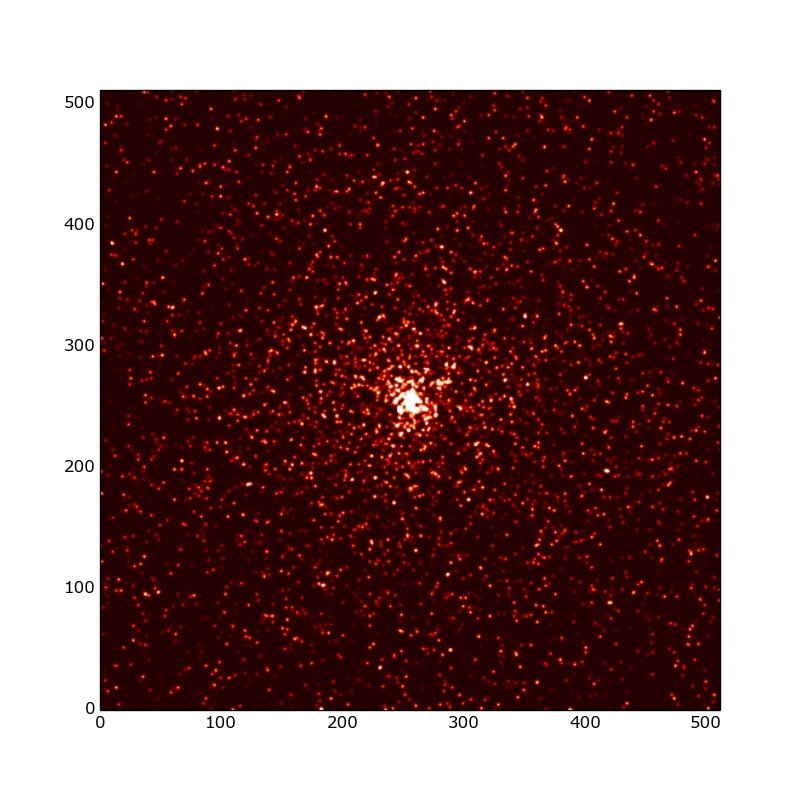

In [14]:
from IPython.display import Image
Image('cluster2.png')

[^Back to top](#Table-of-Contents)

## 4. Separating implementation from user interface

Now we have a new problem--our script is getting long, and a bit jumbled.  We have argument handling, image processing, and file writing all mixed together.  Even though we've done a fairly good job organizing the source into stages, this does not scale well as our script gets more sophisticated and grows from 50 lines to 100 lines to 1000 lines or more (for example the writing stage is just one line right now, but what if we want to add more to the FITS header?  Maybe generate a WCS (which will require a lot more command-line options as well).  Maybe we want to support other output formats.  And of course the image generating itself could grow vastly more sophisticated.

Note also that the code for generating the image has no deep connection to the code for argument handling.  It existed before we added argument parsing.  So maybe that independence should be made explicit by breaking these stages into separate functions.  Note also that generating the image just involved creating a Numpy array.  We don't necessarily have to write that out to a file at all.  Maybe we could use that function as just one step in a pipeline that will do some analysis (source counting, etc.) on our generated image.

To get this script under control we'll start breaking it up into a few different functions.  Remember how for a C program
we had a main function:

    int main(int argc, char** argv) { ... }
    
that receives all the command-line arguments?  Let's make a `main` function in our Python program as well and use that as a place to do all our argument handling:

In [15]:
%%file simcluster.py
#!/usr/bin/env python

import argparse  # We added a new import statement for argarse
import sys       # Also import sys for sys.argv

import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter


def main(argv):
    # Create an ArgumentParser--a special object that keeps track of all the
    # arguments we want our script to be able to handle, and then implements parsing
    # them from sys.argv
    parser = argparse.ArgumentParser(description="Generates simulated images of clusters")

    # Add an optional argument for # of stars (default=10000)
    parser.add_argument('-s', '--stars', type=int, default=10000,
                        help='the number of stars to generate')

    # Add the x and y arguments
    parser.add_argument('-x', type=int, default=512,
                        help='the x dimension (in pixels) of the image')
    parser.add_argument('-y', type=int, default=512,
                        help='the y dimension (in pixels) of the image')

    # Add an argument to handle the output file.  If we use argparse.FileType it will
    # handle opening a writeable file (and ensuring we can write to it).
    # Note that the argument name 'file' does not beging with a '-' or '--'; this indicates
    # to argparse that it is a *positional* argument
    parser.add_argument('file', type=argparse.FileType('w'),
                        help='the name of the output file')

    args = parser.parse_args(argv)

    n_stars = args.stars
    nx = args.x
    ny = args.y
    fileobj = args.file

    # Create empty image
    image = np.zeros((ny, nx))

    # Generate random positions
    r = np.random.random(n_stars) * nx
    theta = np.random.uniform(0., 2. * np.pi, n_stars)

    # Generate random fluxes
    fluxes = np.random.random(n_stars) ** 2

    # Compute position
    x = nx / 2 + r * np.cos(theta)
    y = ny / 2 + r * np.sin(theta)

    # Add stars to image
    # ==> First for loop and if statement <==
    for idx in range(n_stars):
        if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
            image[y[idx], x[idx]] += fluxes[idx]

    # Convolve with a gaussian
    image = gaussian_filter(image, sigma=1)

    # Add noise
    image += np.random.normal(1., 0.001, image.shape)

    # Write to a PNG
    plt.figure(figsize=(8, 8))
    # Nice vmin and vmax were pre-computed using a percentile function, excluded
    # for simplicity of the example
    plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
    plt.savefig(fileobj)

if __name__ == '__main__':
    main(sys.argv[1:])

Overwriting simcluster.py


Now let's move the code for actually generating the pixels of the simulated image into its own function:

In [16]:
%%file simcluster.py
#!/usr/bin/env python

import argparse  # We added a new import statement for argarse
import sys       # Also import sys for sys.argv

import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter


def simulated_cluster(n_stars=10000, dimensions=(512, 512)):
    """
    Generates an image simulating a cluster of stars, including
    a Gaussian filter and background noise.
    
    Parameters
    ----------
    n_stars : `int`
        A positive integer giving the number of visible stars in the image
        (default: 10000).
        
    dimensions : `tuple`
        A two-tuple of positive integers specifying the dimensions (in pixels)
        of the output image (default: 512x512).
        
    Returns
    -------
    array : `~numpy.ndarray`
        A 2D Numpy array containing the pixels of the generated image.
    """ 
        
    nx, ny = dimensions
    
    # Create empty image
    image = np.zeros((ny, nx))

    # Generate random positions
    r = np.random.random(n_stars) * nx
    theta = np.random.uniform(0., 2. * np.pi, n_stars)

    # Generate random fluxes
    fluxes = np.random.random(n_stars) ** 2

    # Compute position
    x = nx / 2 + r * np.cos(theta)
    y = ny / 2 + r * np.sin(theta)

    # Add stars to image
    # ==> First for loop and if statement <==
    for idx in range(n_stars):
        if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
            image[y[idx], x[idx]] += fluxes[idx]

    # Convolve with a gaussian
    image = gaussian_filter(image, sigma=1)

    # Add noise
    image += np.random.normal(1., 0.001, image.shape)
    
    return image


def main(argv):
    """Main function for the simcluster.py script."""
    
    # Create an ArgumentParser--a special object that keeps track of all the
    # arguments we want our script to be able to handle, and then implements parsing
    # them from sys.argv
    parser = argparse.ArgumentParser(description="Generates simulated images of clusters")

    # Add an optional argument for # of stars (default=10000)
    parser.add_argument('-s', '--stars', type=int, default=10000,
                        help='the number of stars to generate')

    # Add the x and y arguments
    parser.add_argument('-x', type=int, default=512,
                        help='the x dimension (in pixels) of the image')
    parser.add_argument('-y', type=int, default=512,
                        help='the y dimension (in pixels) of the image')

    # Add an argument to handle the output file.  If we use argparse.FileType it will
    # handle opening a writeable file (and ensuring we can write to it).
    # Note that the argument name 'file' does not beging with a '-' or '--'; this indicates
    # to argparse that it is a *positional* argument
    parser.add_argument('file', type=argparse.FileType('w'),
                        help='the name of the output file')

    args = parser.parse_args(argv)

    image = simulated_cluster(n_stars=args.stars, dimensions=(args.x, args.y))

    # Write to a PNG
    plt.figure(figsize=(8, 8))
    # Nice vmin and vmax were pre-computed using a percentile function, excluded
    # for simplicity of the example
    plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
    plt.savefig(fileobj)

if __name__ == '__main__':
    main(sys.argv[1:])

Overwriting simcluster.py


The most mysterious aspect of this last version is probably the incantation at the end:

    if __name__ == '__main__':
        main(sys.argv[1:])
        
Clearly this reads `sys.argv` and passes all the argument (except the first, which is the program name) to our `main()` function.  But what is `if __name__ == '__main__':`?

Every Python source file read by Python (also known as a "module" in Python parlance), such as our `simcluster.py` file, automatically gets a variable that is global (to that file, not to the entire Python interpreter) variable called `__name__` defined.  Typically `__name__` just comes from the filename, but with the `.py` stripped off.  Nearly every library or "module" you load in Python comes from a file somewhere, and has this `__name__` attribute.  For example:

In [17]:
import argparse
argparse.__file__

'/usr/lib/python2.7/argparse.pyc'

In [18]:
argparse.__name__

'argparse'

However, there is a caveat.  When we `import argparse`, `argparse.__name__` is the same as the file name.  However, when we run a `.py` file as a *script*, as we are doing when we run `simcluster.py` at the command-line, it gets a special `__name__` with the value `'__main__'`.  We can see this with a simple test script:

In [19]:
%%file maintest.py

print __name__

Writing maintest.py


In [20]:
!python maintest.py

__main__


This is how we know that this file was the main entry point to our program.  Any other Python module imported into our program still reports its normal `__name__`.  (Interesting note, when you run the Python REPL, all the commands you run are actually in a default module called `'__main__'`.  Try it yourself--run `python` and then type `print __name__`).

The reason we put this incantation in our script is to note that we have now separated out a function called `simulated_cluster`, which we might like to use sometime in an interactive Python session, or perhaps as part of a different program.  In other words, `simcluster.py` is no longer just a script--it has also become a (small) *library* of functions, that can also optionally be run as a script.  That is, rather than call `./simcluster.py` from the command-line, we can also *import* it in our Python session:

In [21]:
import simcluster

Note that when we *import* `simcluster`, its `__name__` is no longe `'__main__'`:

In [22]:
simcluster.__name__

'simcluster'

That means we can *import* the module without it automatically running the `main` function of the script.  We can then call functions from within the module in our interactive session:

In [23]:
simcluster.simulated_cluster(100, (10, 10))

array([[ 1.10614415,  1.05495203,  1.03455395,  1.04548228,  1.06436085,
         1.15467841,  1.29346925,  1.33129786,  1.26731978,  1.16338555],
       [ 1.18141255,  1.10695985,  1.07472026,  1.07634616,  1.0731833 ,
         1.09861699,  1.18072147,  1.28127461,  1.32072599,  1.2446052 ],
       [ 1.17239337,  1.12876011,  1.11367811,  1.12253494,  1.13223992,
         1.14233017,  1.19211959,  1.30119626,  1.33720115,  1.2560334 ],
       [ 1.14038214,  1.16094145,  1.19613717,  1.28975709,  1.4009865 ,
         1.42462031,  1.45100868,  1.48628374,  1.39121875,  1.22470269],
       [ 1.14345448,  1.21013123,  1.29082988,  1.49827952,  1.72971181,
         1.74267275,  1.67552843,  1.55199935,  1.33912876,  1.15334036],
       [ 1.10757232,  1.17095043,  1.25039333,  1.46479146,  1.70818612,
         1.68955237,  1.54577571,  1.3606594 ,  1.17351668,  1.06207593],
       [ 1.08503435,  1.11718496,  1.17744253,  1.3454902 ,  1.49309553,
         1.4136245 ,  1.2709269 ,  1.15701316

[^Back to top](#Table-of-Contents)

## 5. Separating library files from program files

We have done a nice job so far of separating the implementation of our algorithm (the actual "science") from the "user-friendly" command-line interface that we now provide to it.  Our `simcluster.py` module is both an importable Python module (or library), but also acts as a command-line program when executed.

However, we can still do better.  There are at least a few issues with this (in the case of this simple program hypothetical, but still realistic for a more complicated application):

1. There's a degree to which, by putting `.py` in the filename, we're exposing how the sausage is made.  Maybe we just want people to be able to make simulated images without knowing or caring what programming language it happened to be implemented in.  We might even change the implementation language in the distant future--or maybe we're writing a replacement for an already existing program.  If we're the only user it doesn't matter so much, but if we want to share our program with colleagues it might be nicer if we just gave them a program called `simcluster` (without the `.py`).

2. Right now our "library" code consists of a single function `simulated_cluster`.  But we've also mentioned that in the future it might grow more components.  Real simulation code might involve dozens of subroutines and utilitiy functions that we might want to break up into separate files.  It might become unmaintainable if we insist that all the code for `simcluster` stay in a single file.

3. Whether our code consists of a single file, or a bundle of files, we want to be able to install it to a standard location on the operating system.  That way we can run the `simcluster` program just like any other program like `ls` or `grep` or `ds9`.  We also want to be able to `import simcluster` from our Python code just like we `import argparse` or `import astropy`.

In this section we'll address the first bullet point.  In the subsequent section we'll address the third.  (The middle bullet point also pertains to the first one, but a little more softfly in our example program since the code is very small.)

What we are going to do now is separate our "library" code, from the command-line interface, this time by moving them into entirely separate files.  The "library" code, currently just consisting of our `simulated_cluster` function can stay where it is in `simcluster.py`.  We will move the `main()` function into a new file called just `simcluster`:

In [24]:
%%file simcluster.py
"""Utilities for generating simulated astronomical images."""

__version__ = '0.1'

import numpy as np
from scipy.ndimage.filters import gaussian_filter


def simulated_cluster(n_stars=10000, dimensions=(512, 512)):
    """
    Generates an image simulating a cluster of stars, including
    a Gaussian filter and background noise.
    
    Parameters
    ----------
    n_stars : `int`
        A positive integer giving the number of visible stars in the image
        (default: 10000).
        
    dimensions : `tuple`
        A two-tuple of positive integers specifying the dimensions (in pixels)
        of the output image (default: 512x512).
        
    Returns
    -------
    array : `~numpy.ndarray`
        A 2D Numpy array containing the pixels of the generated image.
    """ 
        
    nx, ny = dimensions
    
    # Create empty image
    image = np.zeros((ny, nx))

    # Generate random positions
    r = np.random.random(n_stars) * nx
    theta = np.random.uniform(0., 2. * np.pi, n_stars)

    # Generate random fluxes
    fluxes = np.random.random(n_stars) ** 2

    # Compute position
    x = nx / 2 + r * np.cos(theta)
    y = ny / 2 + r * np.sin(theta)

    # Add stars to image
    # ==> First for loop and if statement <==
    for idx in range(n_stars):
        if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
            image[y[idx], x[idx]] += fluxes[idx]

    # Convolve with a gaussian
    image = gaussian_filter(image, sigma=1)

    # Add noise
    image += np.random.normal(1., 0.001, image.shape)
    
    return image

Overwriting simcluster.py


Note that we also added a `__version__` variable in `simcluster.py`, as well as a docstring for the module.  Using `__version__` to specify a library's version is standard practice.  But you should also think about how to use the version number effectively.  Time permitting we can have a discussion about that, but in short there are many documented schemes for how to version your software.  One popular one is called "semantic versions" or "semver" for short.  Most Python projects in the wild use some variation on "semver", if not "semver" in the stricted definition.

In [28]:
%%file simcluster
#!/usr/bin/env python

import sys
import argparse

from matplotlib import pyplot as plt
from simcluster import simulated_cluster

def main(argv):
    """Main function for the simcluster.py script."""
    
    # Create an ArgumentParser--a special object that keeps track of all the
    # arguments we want our script to be able to handle, and then implements parsing
    # them from sys.argv
    parser = argparse.ArgumentParser(description="Generates simulated images of clusters")

    # Add an optional argument for # of stars (default=10000)
    parser.add_argument('-s', '--stars', type=int, default=10000,
                        help='the number of stars to generate')

    # Add the x and y arguments
    parser.add_argument('-x', type=int, default=512,
                        help='the x dimension (in pixels) of the image')
    parser.add_argument('-y', type=int, default=512,
                        help='the y dimension (in pixels) of the image')

    # Add an argument to handle the output file.  If we use argparse.FileType it will
    # handle opening a writeable file (and ensuring we can write to it).
    # Note that the argument name 'file' does not beging with a '-' or '--'; this indicates
    # to argparse that it is a *positional* argument
    parser.add_argument('file', type=argparse.FileType('w'),
                        help='the name of the output file')

    args = parser.parse_args(argv)

    image = simulated_cluster(n_stars=args.stars, dimensions=(args.x, args.y))

    # For now the file writing is simple enough that we leave it in the main() function; in the future
    # we may want to break this out into its own routine that takes a filename and the image array
    # (and any other relevant options) and handles the writing
    # Write to a PNG
    plt.figure(figsize=(8, 8))
    # Nice vmin and vmax were pre-computed using a percentile function, excluded
    # for simplicity of the example
    plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
    plt.savefig(args.file)

if __name__ == '__main__':
    main(sys.argv[1:])

Overwriting simcluster


Note that now all `simcluster.py` contains is a Python function definition.  There is no code in it (like the `main` function) that is executable in the context of a command-line script.  So we will remove the `+x` executable mode from the file (but add it to the new `simcluster` file):

In [29]:
! chmod -x simcluster.py
! chmod +x simcluster

Now run the `simcluster` script like any other executable on your current path:

In [30]:
! ./simcluster

usage: simcluster [-h] [-s STARS] [-x X] [-y Y] file
simcluster: error: too few arguments


If we have a bash shell on Windows the above can also work, but in general a Python script won't be executable on a Windows command prompt.

On Windows it is also possible to create Windows executables (.exe files) from Python scripts.  Python's packaging system will help us with that.

[^Back to top](#Table-of-Contents)

### Bonus enhancement (time permitting)

Getting back to our code, let's see if there some other improvements we can make...

If you look carefully, you'll note also that I now have some repeated information--there are two copies of my default values for `n_stars` and the image dimensions: My `simulated_cluster` function has some default values for those arguments, and I also have a set of defaults that I gave to the `ArgumentParser`.  Maybe I *want* these to have different defaults--there's nothing wrong with that.  But I might also consider some way of adding this information in one place.  There are many approaches one could take for this.  One of the simplest might be a global variable listing defaults in one place:

In [31]:
%%file simcluster.py
"""Utilities for generating simulated astronomical images."""

import numpy as np
from scipy.ndimage.filters import gaussian_filter


CLUSTER_DEFAULTS = {
    'stars': 10000,
    'dimensions': (512, 512)
}


def simulated_cluster(n_stars=CLUSTER_DEFAULTS['stars'], dimensions=CLUSTER_DEFAULTS['dimensions']):
    """
    Generates an image simulating a cluster of stars, including
    a Gaussian filter and background noise.
    
    Parameters
    ----------
    n_stars : `int`
        A positive integer giving the number of visible stars in the image
        (default: 10000).
        
    dimensions : `tuple`
        A two-tuple of positive integers specifying the dimensions (in pixels)
        of the output image (default: 512x512).
        
    Returns
    -------
    array : `~numpy.ndarray`
        A 2D Numpy array containing the pixels of the generated image.
    """ 
        
    nx, ny = dimensions
    
    # Create empty image
    image = np.zeros((ny, nx))

    # Generate random positions
    r = np.random.random(n_stars) * nx
    theta = np.random.uniform(0., 2. * np.pi, n_stars)

    # Generate random fluxes
    fluxes = np.random.random(n_stars) ** 2

    # Compute position
    x = nx / 2 + r * np.cos(theta)
    y = ny / 2 + r * np.sin(theta)

    # Add stars to image
    # ==> First for loop and if statement <==
    for idx in range(n_stars):
        if x[idx] >= 0 and x[idx] < nx and y[idx] >= 0 and y[idx] < ny:
            image[y[idx], x[idx]] += fluxes[idx]

    # Convolve with a gaussian
    image = gaussian_filter(image, sigma=1)

    # Add noise
    image += np.random.normal(1., 0.001, image.shape)
    
    return image

Overwriting simcluster.py


In [ ]:
%%file simcluster
#!/usr/bin/env python

import sys
import argparse

from matplotlib import pyplot as plt
from simcluster import simulated_cluster, CLUSTER_DEFAULTS

def main(argv):
    """Main function for the simcluster.py script."""
    
    # Create an ArgumentParser--a special object that keeps track of all the
    # arguments we want our script to be able to handle, and then implements parsing
    # them from sys.argv
    parser = argparse.ArgumentParser(description="Generates simulated images of clusters")

    # Add an optional argument for # of stars (default=10000)
    parser.add_argument('-s', '--stars', type=int, default=CLUSTER_DEFAULTS['stars'],
                        help='the number of stars to generate')

    # Add the x and y arguments
    parser.add_argument('-x', type=int, default=CLUSTER_DEFAULTS['dimensions'][0],
                        help='the x dimension (in pixels) of the image')
    parser.add_argument('-y', type=int, default=CLUSTER_DEFAULTS['dimensions'][1],
                        help='the y dimension (in pixels) of the image')

    # Add an argument to handle the output file.  If we use argparse.FileType it will
    # handle opening a writeable file (and ensuring we can write to it).
    # Note that the argument name 'file' does not beging with a '-' or '--'; this indicates
    # to argparse that it is a *positional* argument
    parser.add_argument('file', type=argparse.FileType('w'),
                        help='the name of the output file')

    args = parser.parse_args(argv)

    image = simulated_cluster(n_stars=args.stars, dimensions=(args.x, args.y))

    # For now the file writing is simple enough that we leave it in the main() function; in the future
    # we may want to break this out into its own routine that takes a filename and the image array
    # (and any other relevant options) and handles the writing
    # Write to a PNG
    plt.figure(figsize=(8, 8))
    # Nice vmin and vmax were pre-computed using a percentile function, excluded
    # for simplicity of the example
    plt.imshow(image, cmap='gist_heat', origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
    plt.savefig(args.file)

if __name__ == '__main__':
    main(sys.argv[1:])

Another possible approach would have been to determine the default arguments to `simulated_cluster` directly from the function definition itself by using the [`inspect`](https://docs.python.org/2/library/inspect.html) module from the Python standard library.  This will be left as an exercise.

[^Back to top](#Table-of-Contents)

## 6. Making a Python package

The term "package" is woefully overloaded in software engineering.  In this tutorial alone we will use "package" in a different sense in the very next section from this one.  In the most abstract "package" tends to refer to some software bundle consisting of multiple files.  But the purpose for which the files are bundled and how they are organized varies wildly in different contexts.

In the context of this section "package" is being used in the sense of a "Python module package" which is a specific construction in the Python language.

The purpose of a Python package is organize multiple Python files into a single namespace.  Being able to sensibly deal with multiple related source files is critical for any moderately sized software project.  Our `simcluster.py` is only a few dozens of lines long now.  But what happens as we add more features and more kinds of simulations, and suddenly it blows up to a few thousands of lines?  It cn become hard to find anything in a file and to navigate around it in our editor, especially when we're only working on a couple of functions at a time.  Further, even with our code neatly organized into functions, the larger our source code becomes the more our science can become obscured by the nitty-gritty details of our software.  It becomes imperative to break our source code into multiple files.

*How* to break a project up is something of an art form.  There's no one right way, and it can depend in deep ways on how your code works.  It also depends on what type of project is--whether it's a library or an application of some kind.  One *general* organizational principle is to separate the "laboratory" from the "plumbing".  The lab is all our science code--functions that actually implement an algorithm and produce some scientific result.  This code should be as close to *pseudo-code* as possible so that the algorithm can be easier to reason about.  All the "plumbing"--the junk we have to write to interface our science with the computer, such as reading and writing files and manipulating databases, should be broken out into separate files.  We can then write "glue" modules that import all our science code from one (or more) files, and our plumbing from other files, and mix them together to make an application.  We already did this to some extent when we broke our simulation code out from the command-line interface.

Our code right now is simple enough that it's a bit contrived to break it up any further, but let's do it anyways for the demonstration purposes.  In the `simcluster` script we have some code for using `matplotlib` for rendering simulated data to a PNG file.  But let's say our image output code is more complicated (as it can easily become with `matplotlib`).  We may even have a whole suite of different output formats for a data, such as code for producing histograms, or writing to a database.

Let's take our image output code from `simcluster` and put it in a new module called `image_utils.py`:

In [32]:
%%file image_utils.py

from matplotlib import pyplot as plt

def write_png(image, filename, cmap='gist_heat')
    """
    Write the given image array to a PNG file using the specified color map.
    """
    
    plt.figure(figsize=(8, 8))
    # Nice vmin and vmax were pre-computed using a percentile function, excluded
    # for simplicity of the example
    plt.imshow(image, cmap=cmap, origin='bottom', vmin=9.820e-01, vmax=1.168e+00)
    plt.savefig(filename)

Writing image_utils.py


This is very simple for now, but could become arbitrarily complex.

Our `simcluster` script is updated to use `write_png` from `image_utils.py`:

In [33]:
%%file simcluster
#!/usr/bin/env python

import sys
import argparse

from matplotlib import pyplot as plt
from simcluster import simulated_cluster, CLUSTER_DEFAULTS
from image_utils import write_png

def main(argv):
    """Main function for the simcluster.py script."""
    
    # Create an ArgumentParser--a special object that keeps track of all the
    # arguments we want our script to be able to handle, and then implements parsing
    # them from sys.argv
    parser = argparse.ArgumentParser(description="Generates simulated images of clusters")

    # Add an optional argument for # of stars (default=10000)
    parser.add_argument('-s', '--stars', type=int, default=CLUSTER_DEFAULTS['stars'],
                        help='the number of stars to generate')

    # Add the x and y arguments
    parser.add_argument('-x', type=int, default=CLUSTER_DEFAULTS['dimensions'][0],
                        help='the x dimension (in pixels) of the image')
    parser.add_argument('-y', type=int, default=CLUSTER_DEFAULTS['dimensions'][1],
                        help='the y dimension (in pixels) of the image')

    # Add an argument to handle the output file.  If we use argparse.FileType it will
    # handle opening a writeable file (and ensuring we can write to it).
    # Note that the argument name 'file' does not beging with a '-' or '--'; this indicates
    # to argparse that it is a *positional* argument
    parser.add_argument('file', type=argparse.FileType('w'),
                        help='the name of the output file')

    args = parser.parse_args(argv)

    image = simulated_cluster(n_stars=args.stars, dimensions=(args.x, args.y))

    write_png(image, args.file)

if __name__ == '__main__':
    main(sys.argv[1:])

Overwriting simcluster


Now we have a new problem.  In our `simcluster` script, we have a line like `import image_utils`.  When we're just working on our project in isolation that might be fine.  But "image_utils" is a fairly generic name.  Simcluster may be reasonably unique--let's say we've spent some time Googling around to see if anyone else has published a Python project called "simcluster" (in particular we should check the Python Package Index, or PyPI for the name).  But what do want to bet there are other projects out there that have a name like "image_utils"?  This can be a bit subjective, but a generic name like that is usually bad, as it's easy to conflict with something else.

A common example of this occurs when someone puts a bunch of string-related functions into a module called `string.py`.  It turns out the Python standard library also has a module called `string`, but if you have a file called `string.py` on your current working directory, *any* Python code, including code in the standard library, that calls `import string` will use *your* `string` module instead of the real one.  Python will break in wild and bizarre ways.  So be careful when naming modules that it's not something you can already *import*.

To get around this we could do some namespacing at the filename level.  For example we might rename `image_utils.py` to `simcluster_image_utils.py`.  But now we have a longer filename, and this can become tedious (especially when we want even deeper levels of nesting--I have projects that contain several files called "utils.py").  We already have a nicer way to do namespacing built into our filesystem: directories!

The idea of a *Python package* is that it allows us to organize a collection of related Python modules into a directory, and this creates a *namespace* that is the name of that directory.  The idea here is that we take our our ".py" files into a directory, and then instead of importing a file, we in a sense import the name of that directory.  Every module in that directory is imported by joining the directory name and the module name with a `.`.  So just as a Python module creates a namespace of *functions*, a package creates namespace of *modules*.

For example to make `simcluster` into a *package* we would make a directory called "simcluster", and then move `simcluster.py` and `image_utils.py` into that directory.  Now instead of typing `import image_utils` we type `import simcluster.image_utils`.  The original `simcluster.py` is imported now as `simcluster.simcluster`.  This is, of course, annoyingly reundant. But we'll fix that in a bit.

First, if we want to call our package `simcluster` we need to do something about the fact that we already have a *script* called `simcluster`.  Let's reorganize a bit and put our script into a "scripts" directory (this will also serve us well if our project includes multiple command-line scripts).  Then we'll create the `simcluster` directory:

In [34]:
import os
if not os.path.exists('scripts'):
    os.mkdir('scripts')

if os.path.isfile('simcluster'):
    os.rename('simcluster', os.path.join('scripts', 'simcluster'))
    
if not os.path.isdir('simcluster'):
    os.mkdir('simcluster')

Now let's move our `.py` modules into it:

In [35]:
for filename in ['simcluster.py', 'image_utils.py']:
    if os.path.isfile(filename):
        dest = os.path.join('simcluster', filename)
        if os.path.isfile(dest):
            os.remove(dest)
        os.rename(filename, dest)

There's one missing piece we need to make the `simcluster` directory into a *package*.  Python won't just recognize any arbitrary directory as a package.  To make it into a package we need to add a special file to the directory that is always called `__init__.py`.  Although it's a `.py` file it may be completely empty, or contain nothing but a docstring:

In [36]:
%%file simcluster/__init__.py
"""Base package for the simcluster suite."""

Writing simcluster/__init__.py


*(Python 3 note: In Python 3 the `__init__.py` is no longer stricly necessary; any directory on the `sys.path` that recursively contains at least one `.py` file becomes a package.)*

Now we can import our package:

In [37]:
import simcluster
print(simcluster)

<module 'simcluster' from 'simcluster.py'>


First of all, in the above example you may have gotten a module called `simcluster` from `simcluster.py`--the original module we wrote.  If you ran this notebook all in one go, this is because Python caches modules that have already been imported in a single session.  So when you type `import simcluster` it's just going to reuse the old `simcluster` module from earlier in this tutorial.  If you restarted the interpreter at any point you would get the new one.  In order to for Python to reload the new module we have to use the `reload()` function:

In [42]:
import imp
imp.reload(simcluster)
print(simcluster)

<module 'simcluster' from 'simcluster/__init__.pyc'>


Now, from the `print` statement above we can see that `simcluster` *is* a Python module that is in some sense represented by the `simcluster/__init__.py` file we created.

Now there are two newbie traps associated with reorganizing our code into a package.  The first of these is that now that we've imported `simcluster` we might expect to be able to directly access *submodules* like `simcluster.simcluster`, but...

In [43]:
simcluster.simcluster

<module 'simcluster.simcluster' from 'simcluster/simcluster.py'>

It seems that somehow our package does not know about its submodules.  What we can do is explicitly import a submodule like:

In [44]:
import simcluster.simcluster
print(simcluster.simcluster)

<module 'simcluster.simcluster' from 'simcluster/simcluster.py'>


This is an unfortunate but necessary optimization.  When you import a package, Python does not automatically import all *submodules* of that package.  A large package like `numpy` or especially `scipy` may contain *hundreds* of submodules, and importing them all at startup time could cause significant slowdown.  So instead we are forced to only import those modules that we explicitly need.

*(Some projects do use advanced "lazy loading" techniques to fill out the namespace hierarchy without fully importing a package until it is needed--this is difficult to do correctly though, and there are ongoing efforts to add this directly to the Python langage.)*

The other issue is that we've changed our *API*!  What if we have hundreds of users who are already used to being able to use `simcluster.simulated_cluster`.  Or maybe we've already used that in dozens of our own scripts.  If we wanted to change our code to a package we'd have to find everything that uses our code and change our imports...  Or do we?

Remember that empty `__init__.py` file we created?  Well it doesn't *have* to be empty.  It can contain any arbitrary Python code that we want.  In fact when we `import simcluster`, that's really just a shortcut for `simcluster.__init__`.  So anything we put in `__init__.py` is directly available in the top-level `simcluster` namespace.  In particular, we can fill out our top-level namespace by importing whatever we want from our submodules:

In [45]:
%%file simcluster/__init__.py
from .simcluster import simulated_cluster

# Note: Here we don't have "from simcluster", but rather "from .simcluster".  Note the "."--this means import from
# the module called "simcluster" *relative* to the current package.  To import from image_utils we would write:
# from .image_utils import ...

Overwriting simcluster/__init__.py


Now let's try that again.  Note that because we already imported `simcluster` we need to call the `reload()` function on it, since Python will not re-run modules that have already been imported:

In [46]:
import simcluster
import imp
imp.reload(simcluster)
simcluster.simulated_cluster

<function simcluster.simcluster.simulated_cluster>

We can put whatever we want in this namespace, including recreate the original `simcluster` namespace.

You'll find that almost all Python projects that are not one-off analysis scripts are in packages, even if they only consist of one or two files.  This is because it turns out to be less trouble to just make a package in the first place than it is to start without one and then refactor later.

It can even be convenient to organize your one-off scripts in a package, because it's an easier way to share common utility functions between your scripts than repeatedly copy-and-pasting them.

[^Back to top](#Table-of-Contents)

## 7. Packaging and installation

As mentioned in the previous section, although we have nicely separated our library code from our user-interface code, we now have a new problem:  Instead of a nice, single script file that we can e-mail around to our colleagues, we now how two files to deal with, at least one of which depends on the other.  How do we keep things straight--how do we make sure that `simcluster` is executable, and that `simcluster.py` is importable from within Python?

We all have a fairly "standard" execution `$PATH` for our programs (by "standard" we mean standard for a particular platform--this actually varies wildly between OS's):

In [47]:
! echo $PATH

/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games


When we give people (or ourselves) the `simcluster` script we could ask them to copy it to on eof those standard paths.  But which one?  We'd have to give instructions for all OS's, and even with that things can be messy and complicated.  Things get even worse when it comes to Python libraries.  Python has a number of standard paths that it searches for libraries, and this varies depending on what Python version you're using.  To see where Python searches, print out the variable `sys.path` from the `sys` module:

In [48]:
import sys
sys.path

['',
 '/usr/local/lib/python2.7/dist-packages/prettyplotlib-0.1.4-py2.7.egg',
 '/usr/local/lib/python2.7/dist-packages/brewer2mpl-1.3.2-py2.7.egg',
 '/usr/lib/python2.7',
 '/usr/lib/python2.7/plat-x86_64-linux-gnu',
 '/usr/lib/python2.7/lib-tk',
 '/usr/lib/python2.7/lib-old',
 '/usr/lib/python2.7/lib-dynload',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages/PILcompat',
 '/usr/lib/python2.7/dist-packages/gst-0.10',
 '/usr/lib/python2.7/dist-packages/gtk-2.0',
 '/usr/lib/pymodules/python2.7',
 '/usr/lib/python2.7/dist-packages/ubuntu-sso-client',
 '/usr/lib/python2.7/dist-packages/wx-2.8-gtk2-unicode',
 '/usr/local/lib/python2.7/dist-packages/IPython/extensions',
 '/home/iguananaut/.ipython']

Each value in `sys.path` is a directory on your filesystem.  When you run the code `import simcluster` it searches each of those directories, in order (the first entry `''` means the current directory) for a file called `simcluster.py` to import.  

*Note*: Alternatively, it looks for a directory called `simcluster` containing a file named `simcluster/__init__.py`.  That indicates that `simcluster` is a "package", which is beyond the scope of this tutorial.

Knowing where to properly install a Python module can be a nightmare for novices.

Fortunately, your Python distribution *does* know where best to install both scripts and Python modules (so long as you have permission to install to those locations--there are ways of specifying alternative paths, but that is again outside the scope of this tutorial).  

The "standard" way to install Python software is to write a special script called `setup.py`, which uses a library called `setuptools` (or sometimes the older `distutils`).  You may have seen this before if you have ever downloaded a third-party Python library.  The library probably came in some archive file (either `.zip` or `.tar.gz`) containing all the source code for the library and/or scripts, along with a `setup.py` file, and a few other files (a license, a README, etc.)

Users can simply unpack the archive, and run the command

    ./setup.py install
    
to install all the software in your package to the correct locations for your particular Python distribution (this will work even with Anaconda and the like).  The key is that you don't have to implement the details of how this command works.  All of that is already done by Python.  All you have to do is provide a little boilerplate in the `setup.py` file that looks something like:

In [49]:
%%file setup.py
#!/usr/bin/env python

from setuptools import setup
import os

setup(
    name='simcluster',
    author='Your Name Here!',
    author_email='your.name@example.com',  # so people can pester you ;)
    version='0.1',
    packages=['simcluster'],  # Python packages to install
    # (If we have individual .py modules we can use the py_module argument instead)
    # This is the full name of the script "simcluster"; this will be installed to a
    # bin/ directory
    scripts=[os.path.join('scripts', 'simcluster')]
)

Writing setup.py


When the `setup.py` script is run all that happens is the `setup()` function is called.  This passes all the information about your project to the Python setuptools/distutils infrastructure, and it uses it to implement an entire command-line interface for building and installing your project, as we'll see.

Next, be kind to your users and make the `setup.py` script executable as well:

In [50]:
! chmod +x setup.py

Now when we run this `setup.py` we can see that it implements a whole lot of functionality that we didn't have to write:

In [51]:
! ./setup.py --help

Common commands: (see '--help-commands' for more)

  setup.py build      will build the package underneath 'build/'
  setup.py install    will install the package

Global options:
  --verbose (-v)      run verbosely (default)
  --quiet (-q)        run quietly (turns verbosity off)
  --dry-run (-n)      don't actually do anything
  --help (-h)         show detailed help message
  --no-user-cfg       ignore pydistutils.cfg in your home directory
  --command-packages  list of packages that provide distutils commands

Information display options (just display information, ignore any commands)
  --help-commands     list all available commands
  --name              print package name
  --version (-V)      print package version
  --fullname          print <package name>-<version>
  --author            print the author's name
  --author-email      print the author's email address
  --maintainer        print the maintainer's name
  --maintainer-email  print the maintainer's email address
  --co

To install the package we just run `./setup.py install`.  We can also run `./setup.py install --help` to see additional options for controlling where files are installed to.  But in general, it will by default copy files to their appropriate locations (so long as you have permission to write to those locations on the filesystem-- you may have to run `sudo ./setup.py install`).

`setup.py` also provides us with a number of other services.  For example, it was mentioned earlier that when you download a Python library it comes in an archive file (usually referred to as a "source distribution").  Well, you can make your own simply by running:

In [52]:
! ./setup.py sdist

running sdist
running egg_info
creating simcluster.egg-info
writing simcluster.egg-info/PKG-INFO
writing top-level names to simcluster.egg-info/top_level.txt
writing dependency_links to simcluster.egg-info/dependency_links.txt
writing manifest file 'simcluster.egg-info/SOURCES.txt'
reading manifest file 'simcluster.egg-info/SOURCES.txt'
writing manifest file 'simcluster.egg-info/SOURCES.txt'

running check

creating simcluster-0.1
creating simcluster-0.1/scripts
creating simcluster-0.1/simcluster
creating simcluster-0.1/simcluster.egg-info
making hard links in simcluster-0.1...
hard linking setup.py -> simcluster-0.1
hard linking scripts/simcluster -> simcluster-0.1/scripts
hard linking simcluster/__init__.py -> simcluster-0.1/simcluster
hard linking simcluster/image_utils.py -> simcluster-0.1/simcluster
hard linking simcluster/simcluster.py -> simcluster-0.1/simcluster
hard linking simcluster.egg-info/PKG-INFO -> simcluster-0.1/simcluster.egg-info
hard linking simcluster.egg-info/SOUR

This automatically creates an archive with all the required files for your project (though sometimes you need to hold its hand a bit for it to know what all the files are that it needs, see [Python documentation](https://docs.python.org/2/distutils/sourcedist.html#specifying-the-files-to-distribute) for more details).

By default, it automatically creates the file in a subdirectory of your project called `dist/` (*note* on OSX and Linux it usually creates a `.tar.gz` by default, while on Windows it creates a `.zip` by default, so the following example may not work on Windows):

In [53]:
! tar -tf dist/simcluster-0.1.tar.gz

simcluster-0.1/
simcluster-0.1/PKG-INFO
simcluster-0.1/setup.cfg
simcluster-0.1/scripts/
simcluster-0.1/scripts/simcluster
simcluster-0.1/simcluster/
simcluster-0.1/simcluster/image_utils.py
simcluster-0.1/simcluster/__init__.py
simcluster-0.1/simcluster/simcluster.py
simcluster-0.1/simcluster.egg-info/
simcluster-0.1/simcluster.egg-info/SOURCES.txt
simcluster-0.1/simcluster.egg-info/PKG-INFO
simcluster-0.1/simcluster.egg-info/dependency_links.txt
simcluster-0.1/simcluster.egg-info/top_level.txt
simcluster-0.1/setup.py


Finally, if you're really ambitious and want to share your code with the rest of the world you can post it to [PyPI](https://pypi.python.org/pypi), the Python Package Index (also known to old-timers as "the cheeseshop").  When your project is on PyPI then people don't even have to manually download and unpack the source distribution.  They can just install your package with [`pip`](https://pip.pypa.io/en/latest/index.html), the Python installer.  You can just tell your users to run:

    pip install simcluster
    
and pip will do the rest.  This only works if your project has a `setup.py` that implements these standard interfaces.  If you have an account on PyPI you can post your project to PyPI by running:

    ./setup.py register sdist upload
    
This is actually three commands in one:  the `register` command tells PyPI you want to reserve a project name called "simcluster" and that its latest version is "0.1" (along with any other metadata you provided `setup.py` such as your name).  Then `sdist` builds a source distribution archive as we already saw.  Finally `upload` uploads the source archive to PyPI (this is separate from `register` which only posts the metadata).

You are now the proud owner of a Python package!

[^Back to top](#Table-of-Contents)